# NOTEBOOK GENERATE PROMPTS WITH MITIGATIONS

This notebook generate prompts with the specific mitigations for IoT generated by deepseek using CAPEC.

## 1. OBJECTIVES

This notebook is designed to generate structured prompts enriched with specific mitigations. These prompts will later be used for fine-tuning LLM models.

## 2. IMPORTS AND SETUP
Import the required python libraries, for the prompts generation.

In [1]:
# pandas and os imports
import pandas as pd
import os
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# json import
import json

## 3. DATA PREPARATION
Load the EdgeIIoT dataset.

In [2]:
# Read dataset
csv_path = "../../data/dataset-csv/DNN-EdgeIIoT-dataset.csv"
df = pd.read_csv(csv_path,low_memory=False)
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [3]:
# View columns
print(df.columns)

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused',
       'http.file_data', 'http.content_length', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack',
       'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack',
       'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options',
       'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream',
       'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu',
       'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request',
       'dns.retransmit_request_in', 'mqtt.conack.flags',
       'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len

In [4]:
# Save a backup of the dataframe
df_bp = df

## 4. DATA ANALYSIS
Analyze the dataset to preprocess it. 

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# View if there is any missing data
df.isna().sum()

frame.time                   0
ip.src_host                  0
ip.dst_host                  0
arp.dst.proto_ipv4           0
arp.opcode                   0
arp.hw.size                  0
arp.src.proto_ipv4           0
icmp.checksum                0
icmp.seq_le                  0
icmp.transmit_timestamp      0
icmp.unused                  0
http.file_data               0
http.content_length          0
http.request.uri.query       0
http.request.method          0
http.referer                 0
http.request.full_uri        0
http.request.version         0
http.response                0
http.tls_port                0
tcp.ack                      0
tcp.ack_raw                  0
tcp.checksum                 0
tcp.connection.fin           0
tcp.connection.rst           0
tcp.connection.syn           0
tcp.connection.synack        0
tcp.dstport                  0
tcp.flags                    0
tcp.flags.ack                0
tcp.len                      0
tcp.options                  0
tcp.payl

## 5. FEATURE SELECTION AND PREPROCESSING
Select the most important features using a random forest classifier to select the best 7 features.

dns.qry.name.len     0.205840
mqtt.protoname       0.138802
mqtt.msg             0.109687
mqtt.topic           0.101408
mqtt.conack.flags    0.095618
tcp.options          0.081726
tcp.dstport          0.055727
dtype: float64


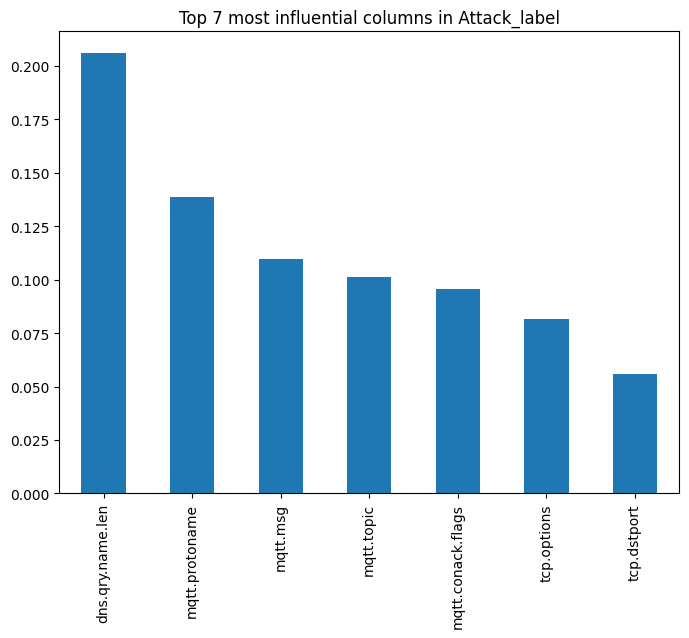

In [ ]:
# Convert Attack_label to an integer (0 or 1)
df["Attack_label"] = df["Attack_label"].astype(int)

# Remove unnecessary columns
df = df.drop(["frame.time", "Attack_type"], axis=1, errors="ignore")

# Convert categorical variables into numerical values
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target variable
X = df.drop(columns=["Attack_label"])
y = df["Attack_label"]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the top 7 most influential features
print(feature_importance.head(7))

# Plot feature importance
plt.figure(figsize=(8,6))
feature_importance.head(7).plot(kind="bar")
plt.title("Top 7 most influential columns in Attack_label")
plt.show()

In [8]:
# Define the selected columns
selected_columns = [
    "dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags",
    "tcp.options", "tcp.dstport"
]

## 6. TRIM DATASET
Trim the dataset to obtain 1k samples from each class in order to subsequently generate the prompt dataset

In [9]:
# Get the selected columns from the original dataframe including the attack type
df_selected_multiclass = df_bp[selected_columns + ["Attack_type"]]

In [10]:
# Define number of samples per class
samples_per_class = 1000

# Check if "Attack_type" exists in df_selected
if "Attack_type" not in df_selected_multiclass.columns:
    raise ValueError("Column 'Attack_type' not found in df_selected_multiclass. Check your DataFrame.")

# Select 1000 samples for "Normal" traffic
normal_samples = df_selected_multiclass[df_selected_multiclass["Attack_type"] == "Normal"].sample(
    n=min(samples_per_class, len(df_selected_multiclass[df_selected_multiclass["Attack_type"] == "Normal"])),
    random_state=42
)

# Select 1000 samples for each attack type
attack_samples = df_selected_multiclass[df_selected_multiclass["Attack_type"] != "Normal"].groupby("Attack_type").apply(
    lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)
).reset_index(drop=True)

# Combine normal and attack samples into the balanced dataset
df_balanced = pd.concat([normal_samples, attack_samples])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipykernel_9691/2533074083.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  attack_samples = df_selected_multiclass[df_selected_multiclass["Attack_type"] != "Normal"].groupby("Attack_type").apply(


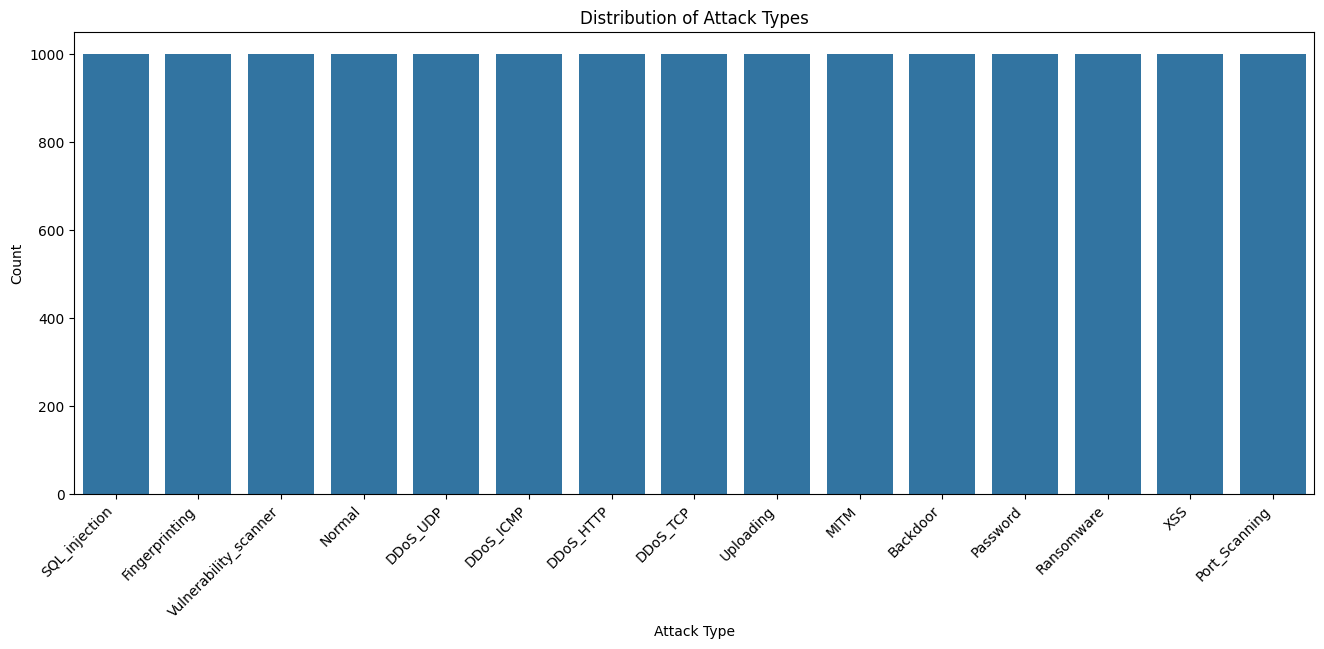

In [11]:
# Count occurrences of each class
# Set a wider figure size
plt.figure(figsize=(16, 6))

# Count occurrences of each attack type
sns.countplot(x=df_balanced["Attack_type"])
plt.title("Distribution of Attack Types")
plt.xlabel("Attack Type")
plt.ylabel("Count")

# Rotate x-axis labels by 45 degrees to prevent overlap
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

## 7. GENERATE PROMPTS
Combine the trimmed dataset and the mitigations previously obtained with DeepSeek to generate the prompts, including the logs and the mitigations.

In [12]:
# Read mitigations from json file and create a dictionary
dir = "../../data/capec/"
filename = "attack_mitigations.jsonl"
file_path = os.path.join(dir, filename)
mitigation_dict = {}
with open(file_path, "r") as f:
    for line in f:
        item = json.loads(line)
        mitigation_dict[item["attack"]] = item["mitigations"]

In [13]:
# Define the directory and output filename. Create the folder if not exists.
save_dir = "../../data/prompts/"
save_filename = "multiclass_instructions_with_mitigations.jsonl"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, save_filename)

# Format of the prompt
prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.
### Instruction:
You are a cybersecurity expert specializing in IoT security. Your task is to analyze network logs and determine whether the given log data indicates a potential attack. Only provide the type of attack if it is an attack. If the log data is normal traffic, state that it is normal traffic. If it is an attack, also include 4 to 5 specific technical mitigations.
### Question:
{}
### Response:
<think>
{}
</think>"""

# Descriptions for each column. These descriptions will be used in the prompt.
column_descriptions = {
    "dns.qry.name.len": "The length of the DNS query is:",
    "mqtt.protoname": "The MQTT protocol name used is:",
    "mqtt.msg": "The MQTT message type is:",
    "mqtt.topic": "The MQTT topic is:",
    "mqtt.conack.flags": "The MQTT connection acknowledgment flags are:",
    "tcp.options": "TCP options set in the packet are:",
    "tcp.dstport": "TCP destination port is:"
}

# Function to create prompts with mitigations if there is attack
def create_prompt(features, label):
    log_details = "\n".join([f"- {column_descriptions.get(col, col)} {features[col]}" for col in features.index])
    if label.lower() == "normal":
        label_text = "This log data is normal traffic."
    else:
        mitigations = mitigation_dict.get(label, [])
        mitigations_text = "\n".join([f"{m.strip()}" for m in mitigations[:5]])
        label_text = f"This log data is an attack!! The type of attack detected is {label}.\n\nMitigations:\n{mitigations_text}"
    return prompt_style.format(log_details, label_text)

# Apply the function to create the prompt
df_balanced["Prompt"] = df_balanced.apply(lambda row: create_prompt(row.drop("Attack_type"), row["Attack_type"]), axis=1)

# Save at the json file
df_balanced[["Prompt"]].to_json(save_path, orient="records", lines=True, force_ascii=False)

# Multi-class prompt dataset
print(f"Multi-class prompt dataset successfully saved at: {save_path}")

Multi-class prompt dataset successfully saved at: ../../data/prompts/multiclass_instructions_with_mitigations.jsonl
